# TBX1 Cohort Analysis Report

##### TBX1 or T box 1 is a transcription factor crucial for the prenatal establishment of the thymus [1]. In humans, monoallelic loss-of-function mutations in TBX1 have been associated with the development of velo-cardio-facial, or DiGeorge, syndrome [2]. Interestingly, missense mutations leading to increased TBX1 activity also result in phenotypically similar syndrome [3] - characterized by velopharyngeal insufficiency, hypoplastic thymus, immunodeficiency, hypoparathyroidism, craniofacial dysmorphia, hearing impairment and cardiac defect [4–10]. The mutations seem highly variably penetrant, with some patients presenting without signs of immunodeficiency, while others present with life-threatening congenital athymia requiring corrective treatment with a thymic transplant [11,12].
##### In our analysis, we collated 39 patients from the published literature, annotated them with HPO terms, created Phenopackets [13] and then performed GPSEA analysis. Overall we identified 19 variants and annotated patients with 57 different HPO terms.
##### When comparing the phenotype of patients with missense (n = 9), frameshift (n = 17) and 5-prime untranslated region (UTR) variants (n = 5) for all annotated features, ventricular septal defects (HPO:0001629) and hypertelorism (HPO:0000316) seemed to be significantly dysproportionately associated with missense and UTR variants (p = 0.01) and frameshift variants (p = 0.02) respectively, however, upon multiple comparisons adjustment this association became insignificant.
##### While the Frameshift and Missense variants are expected to result in impaired function or levels of the gene's product, the 5’UTR variant was reported to increase expression of TBX1. Therefore, we have also compared Frameshift and Missense variants to each other. Since the variants published in a larger number of patients were well annotated, we also performed comparison of the 3 most frequent variants. Despite low total number of patients (5,5 and 4), this comparison resulted in significant results for blepharophimosis [HP:0000581] and narrow nose [HP:0000460], showing the need for high quality annotation of the dataset over absolute number of subjects. 
##### We have therefore also attempted to reduce the high number of tests by excluding closely related HPO terms (e.g. excluding specific heart defects and using only the Abnormality of the cardiovascular system [HP:0001626] term. We have also compared only the well-annotated terms (with less than 33% of NAs across the cohort). These changes did not lead to significant increase in performance of the method.


In [105]:
import gpsea
import hpotk
import pandas as pd
import pyphetools as pyphetools
import glob
from gpsea import *
from gpsea.preprocessing import load_phenopacket_files
from gpsea.preprocessing import configure_caching_cohort_creator

cohort = "TBX1"
tx_id = 'NM_001379200.1'
px_id = 'NP_001366129.1'

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
cohort_creator = configure_caching_cohort_creator(hpo)


In [106]:
directory_path = 'C:/Users/vladyka47994/OneDrive - Univerzita Karlova/WG Klocperk/Project TBX1 phenopackets/ppOndra39'

pp_files = glob.glob(f'{directory_path}/*.json')

#print(pp_files)

cohort, qc_results = load_phenopacket_files(pp_files, cohort_creator)


Individuals Processed: 39individuals [00:00, 214.37individuals/s]


In [107]:
import pandas as pd
from gpsea.model import ProteinMetadata
domains = [
   {"region": "Tbox","category": "region", "start": 123, "end": 306, },
    {"region": "Disordered","category": "region", "start": 38, "end": 81, },
    {"region": "Disordered","category": "region", "start": 331, "end": 352, },
    {"region": "Disordered","category": "region", "start": 388, "end": 422, },
    {"region": "Compositional_bias","category": "region", "start": 46, "end": 81, },

]
df = pd.DataFrame(domains)

## Quality Control

In [109]:
qc_results.summarize()


Validated under none policy
No errors or warnings were found


## Cohort Overview


In [111]:
from gpsea.view import CohortViewable
from IPython.display import display, HTML, IFrame

# Create the cohort report as HTML
viewer = CohortViewable(hpo)
report = viewer.process(cohort=cohort, transcript_id=tx_id)

# Save the report as an HTML file
with open('tbx1_cohort_info.html', 'w') as fh:
    _ = fh.write(report)

# Display the report in the notebook
display(IFrame('tbx1_cohort_info.html', '100%', '600px'))

## 4. Visualizing the TBX1 Protein Structure

We visualize the TBX1 protein structure and save the image.


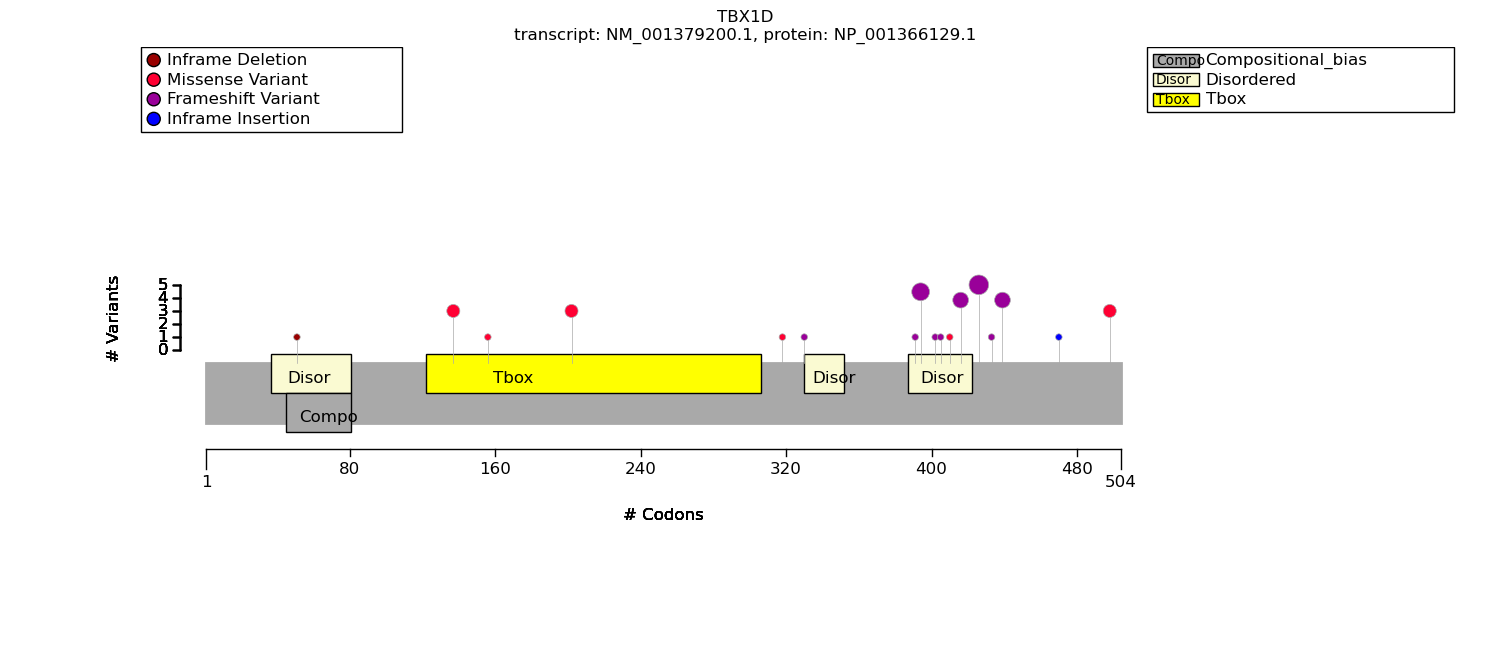

In [113]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
txc_service = VVMultiCoordinateService(genome_build=GRCh38)

tx_coordinates = txc_service.fetch(tx_id)
protein_meta = ProteinMetadata.from_feature_frame(
    protein_id="NP_001366129.1",
    label="TBX1D",
    features=df,
    protein_length=504,
)
pms = configure_default_protein_metadata_service()
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
fig.tight_layout()
fig.savefig('tbx1_protein_diagram2.png')


## Genotype-Phenotype Comparison

We analyze the genotype-phenotype relationships by comparing different variant effects.


In [116]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import *


gt_predicate = groups_predicate(
    predicates=(VariantPredicates.variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id), 
                VariantPredicates.variant_effect(VariantEffect.FRAMESHIFT_VARIANT, tx_id),
                VariantPredicates.variant_effect(VariantEffect.FIVE_PRIME_UTR_VARIANT, tx_id)
    ),
    group_names=("MISSENSE", "FRAMESHIFT", '5_prime')
)

from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest

pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
    min_n_of_patients_with_term=3,
)


In [118]:
from gpsea.analysis.mtc_filter import HpoMtcFilter
mtc_filter = HpoMtcFilter.default_filter(hpo, term_frequency_threshold=0.3)
mtc_correction = 'fdr_bh'
mtc_alpha = 0.05

from gpsea.analysis.pcats.stats import FisherExactTest
count_statistic = FisherExactTest()


In [121]:
from gpsea.analysis.pcats import HpoTermAnalysis
analysis = HpoTermAnalysis(
    count_statistic=count_statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
    mtc_alpha=mtc_alpha,
)

result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)


In [124]:
from gpsea.view import summarize_hpo_analysis
import pandas as pd
summary_df = summarize_hpo_analysis(hpo, result)

 # Comparison of 3 main variant classes


In [126]:
display(summary_df)

Genotype group                                MISSENSE         FRAMESHIFT  \
                                                 Count Percent      Count   
Ventricular septal defect [HP:0001629]             5/9     56%       1/17   
Hypertelorism [HP:0000316]                         2/5     40%      11/15   
Upslanted palpebral fissure [HP:0000582]           0/5      0%       0/15   
Pulmonary valve atresia [HP:0010882]               3/8     38%       1/17   
Abnormal facial shape [HP:0001999]                 6/9     67%      19/20   
Global developmental delay [HP:0001263]            1/6     17%       8/19   
Hypoparathyroidism [HP:0000829]                    2/6     33%      11/17   
Tetralogy of Fallot [HP:0001636]                   2/7     29%       1/17   
Sensorineural hearing impairment [HP:0000407]      1/4     25%       7/13   
Low-set ears [HP:0000369]                          4/7     57%      12/16   
Blepharophimosis [HP:0000581]                      4/7     57%       6/16   
Narrow nose [HP:0000460]                           0/3      0%       5/13   
Bulbous nose [HP:0000414]                          0/3      0%       4/13   
Micrognathia [HP:0000347]                          4/7     57%       7/15   

Genotype group                                        5_prime          \
                                              Percent   Count Percent   
Ventricular septal defect [HP:0001629]             6%     2/5     40%   
Hypertelorism [HP:0000316]                        73%     0/3      0%   
Upslanted palpebral fissure [HP:0000582]           0%     2/5     40%   
Pulmonary valve atresia [HP:0010882]               6%     2/5     40%   
Abnormal facial shape [HP:0001999]                95%     2/3     67%   
Global developmental delay [HP:0001263]           42%     3/3    100%   
Hypoparathyroidism [HP:0000829]                   65%     0/3      0%   
Tetralogy of Fallot [HP:0001636]                   6%     2/5     40%   
Sensorineural hearing impairment [HP:0000407]     54%     0/3      0%   
Low-set ears [HP:0000369]                         75%     1/3     33%   
Blepharophimosis [HP:0000581]                     38%     0/3      0%   
Narrow nose [HP:0000460]                          38%     0/3      0%   
Bulbous nose [HP:0000414]                         31%     0/3      0%   
Micrognathia [HP:0000347]                         47%     1/3     33%   

Genotype group                                                              
                                              Corrected p values  p values  
Ventricular septal defect [HP:0001629]                  0.153643  0.010975  
Hypertelorism [HP:0000316]                              0.155718  0.029658  
Upslanted palpebral fissure [HP:0000582]                0.155718  0.066667  
Pulmonary valve atresia [HP:0010882]                    0.155718  0.068368  
Abnormal facial shape [HP:0001999]                      0.155718  0.071021  
Global developmental delay [HP:0001263]                 0.155718  0.076838  
Hypoparathyroidism [HP:0000829]                         0.155718  0.085793  
Tetralogy of Fallot [HP:0001636]                        0.155718  0.088982  
Sensorineural hearing impairment [HP:0000407]           0.432473  0.278019  
Low-set ears [HP:0000369]                               0.461960  0.360200  
Blepharophimosis [HP:0000581]                           0.461960  0.362968  
Narrow nose [HP:0000460]                                0.477984  0.409701  
Bulbous nose [HP:0000414]                               0.600143  0.557276  
Micrognathia [HP:0000347]                               1.000000  1.000000

In [127]:
from gpsea.analysis.predicate.genotype import VariantPredicates, groups_predicate
from gpsea.analysis.pcats.stats import FisherExactTest

gt_predicate = groups_predicate(
    predicates=(VariantPredicates.variant_key('22_19766631_19766632_TA_T'), 
                VariantPredicates.variant_key('22_19760805_19760805_C_T'),
                VariantPredicates.variant_key('22_19766537_19766538_CG_T'),
    ),
    group_names=("22_19766631_19766632_TA_T", "22_19760805_19760805_C_T", '22_19766537_19766538_CG_T')
)
gt_predicate.display_question()
'Allele group: A1, A2, A3'

from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest

pheno_predicates = prepare_predicates_for_terms_of_interest(
        cohort=cohort,
        hpo=hpo,
        min_n_of_patients_with_term=2,
    )

from gpsea.analysis.mtc_filter import HpoMtcFilter
mtc_filter = HpoMtcFilter.default_filter(hpo, term_frequency_threshold=0.2)
mtc_correction = 'fdr_bh'
mtc_alpha = 0.05


from gpsea.analysis.pcats.stats import *
count_statistic = FisherExactTest()


from gpsea.analysis.pcats import HpoTermAnalysis
analysis = HpoTermAnalysis(
    count_statistic=count_statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
    mtc_alpha=mtc_alpha,
)

result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)
result.total_tests

len(result.phenotypes)



129

In [128]:
from gpsea.view import MtcStatsViewer
mtc_viewer = MtcStatsViewer()
mtc_report = mtc_viewer.process(result)
with open('tbx1_variants.mtc_report.html', 'w') as fh:
    _ = fh.write(mtc_report)


from gpsea.view import summarize_hpo_analysis
summary_df = summarize_hpo_analysis(hpo, result)

# Comparison of top 3 variants

In [130]:
display(summary_df)

Genotype group                                22_19766631_19766632_TA_T  \
                                                                  Count   
Blepharophimosis [HP:0000581]                                       5/5   
Narrow nose [HP:0000460]                                            5/5   
Hypertelorism [HP:0000316]                                          5/5   
Bulbous nose [HP:0000414]                                           0/5   
Global developmental delay [HP:0001263]                             5/5   
Hypoparathyroidism [HP:0000829]                                     3/5   
Micrognathia [HP:0000347]                                           5/5   
Low-set ears [HP:0000369]                                           5/5   
Sensorineural hearing impairment [HP:0000407]                       1/5   
Abnormal facial shape [HP:0001999]                                  5/5   
Tetralogy of Fallot [HP:0001636]                                    0/5   
Pulmonary valve atresia [HP:0010882]                                0/5   
Ventricular septal defect [HP:0001629]                              0/5   
Upslanted palpebral fissure [HP:0000582]                            0/5   

Genotype group                                         \
                                              Percent   
Blepharophimosis [HP:0000581]                    100%   
Narrow nose [HP:0000460]                         100%   
Hypertelorism [HP:0000316]                       100%   
Bulbous nose [HP:0000414]                          0%   
Global developmental delay [HP:0001263]          100%   
Hypoparathyroidism [HP:0000829]                   60%   
Micrognathia [HP:0000347]                        100%   
Low-set ears [HP:0000369]                        100%   
Sensorineural hearing impairment [HP:0000407]     20%   
Abnormal facial shape [HP:0001999]               100%   
Tetralogy of Fallot [HP:0001636]                   0%   
Pulmonary valve atresia [HP:0010882]               0%   
Ventricular septal defect [HP:0001629]             0%   
Upslanted palpebral fissure [HP:0000582]           0%   

Genotype group                                22_19760805_19760805_C_T  \
                                                                 Count   
Blepharophimosis [HP:0000581]                                      0/3   
Narrow nose [HP:0000460]                                           0/3   
Hypertelorism [HP:0000316]                                         0/3   
Bulbous nose [HP:0000414]                                          0/3   
Global developmental delay [HP:0001263]                            3/3   
Hypoparathyroidism [HP:0000829]                                    0/3   
Micrognathia [HP:0000347]                                          1/3   
Low-set ears [HP:0000369]                                          1/3   
Sensorineural hearing impairment [HP:0000407]                      0/3   
Abnormal facial shape [HP:0001999]                                 2/3   
Tetralogy of Fallot [HP:0001636]                                   2/5   
Pulmonary valve atresia [HP:0010882]                               2/5   
Ventricular septal defect [HP:0001629]                             2/5   
Upslanted palpebral fissure [HP:0000582]                           2/5   

Genotype group                                         \
                                              Percent   
Blepharophimosis [HP:0000581]                      0%   
Narrow nose [HP:0000460]                           0%   
Hypertelorism [HP:0000316]                         0%   
Bulbous nose [HP:0000414]                          0%   
Global developmental delay [HP:0001263]          100%   
Hypoparathyroidism [HP:0000829]                    0%   
Micrognathia [HP:0000347]                         33%   
Low-set ears [HP:0000369]                         33%   
Sensorineural hearing impairment [HP:0000407]      0%   
Abnormal facial shape [HP:0001999]                67%   
Tetralogy of Fall

In [131]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import VariantPredicates, monoallelic_predicate

non_5prime = ~VariantPredicates.variant_effect(VariantEffect.FIVE_PRIME_UTR_VARIANT, tx_id)
gt_predicate = groups_predicate(
    predicates=(VariantPredicates.variant_effect(VariantEffect.FIVE_PRIME_UTR_VARIANT, tx_id),
        ~VariantPredicates.variant_effect(VariantEffect.FIVE_PRIME_UTR_VARIANT, tx_id),
    ),
    group_names=("5prime", "other",)
)

from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest

pheno_predicates = prepare_predicates_for_terms_of_interest(
        cohort=cohort,
        hpo=hpo,
        missing_implies_excluded = False,
        min_n_of_patients_with_term=2,
    )

from gpsea.analysis.mtc_filter import HpoMtcFilter
mtc_filter = HpoMtcFilter.default_filter(hpo, term_frequency_threshold=0.2)
mtc_correction = 'fdr_bh'
mtc_alpha = 0.05


from gpsea.analysis.pcats.stats import FisherExactTest
count_statistic = FisherExactTest()


from gpsea.analysis.pcats import HpoTermAnalysis
analysis = HpoTermAnalysis(
    count_statistic=count_statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
    mtc_alpha=mtc_alpha,
)

result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)
result.total_tests

len(result.phenotypes)

from gpsea.view import summarize_hpo_analysis
import pandas as pd

# Summarize the HPO analysis into a DataFrame
summary_df = summarize_hpo_analysis(hpo, result)

# Save to CSV file
summary_df.to_csv('tbx1_5prime_vs_other.csv')


 # 5 prime UTR variant vs all others

In [133]:
display(summary_df)

Genotype group                                     5prime          other  \
                                                    Count Percent  Count   
Upslanted palpebral fissure [HP:0000582]              2/5     40%   0/21   
Global developmental delay [HP:0001263]               3/3    100%   9/29   
Hypoparathyroidism [HP:0000829]                       0/3      0%  16/26   
Hypertelorism [HP:0000316]                            0/3      0%  13/21   
Tetralogy of Fallot [HP:0001636]                      2/5     40%   3/26   
Pulmonary valve atresia [HP:0010882]                  2/5     40%   4/27   
Blepharophimosis [HP:0000581]                         0/3      0%  10/24   
Sensorineural hearing impairment [HP:0000407]         0/3      0%   8/20   
Low-set ears [HP:0000369]                             1/3     33%  16/24   
Narrow nose [HP:0000460]                              0/3      0%   5/17   
Ventricular septal defect [HP:0001629]                2/5     40%   6/28   
Micrognathia [HP:0000347]                             1/3     33%  11/23   
Abnormal facial shape [HP:0001999]                    2/3     67%  25/33   
Conotruncal defect [HP:0001710]                       2/2    100%    3/5   
Congenital malformation of the great arteries [...    2/2    100%    4/6   
Abnormal morphology of the great vessels [HP:00...    2/2    100%    5/7   
Abnormal blood vessel morphology [HP:0033353]         2/2    100%    5/7   
Abnormal ventriculoarterial connection [HP:0011...    2/2    100%    4/6   
Abnormal pulmonary valve morphology [HP:0001641]      2/2    100%    4/6   
Abnormal cardiac septum morphology [HP:0001671]       2/2    100%    6/8   
Abnormal ventricular septum morphology [HP:0010...    2/2    100%    6/8   
Bulbous nose [HP:0000414]                             0/3      0%   4/17   

Genotype group                                                                 \
                                                   Percent Corrected p values   
Upslanted palpebral fissure [HP:0000582]                0%           0.448370   
Global developmental delay [HP:0001263]                31%           0.448370   
Hypoparathyroidism [HP:0000829]                        62%           0.448370   
Hypertelorism [HP:0000316]                             62%           0.448370   
Tetralogy of Fallot [HP:0001636]                       12%           0.760848   
Pulmonary valve atresia [HP:0010882]                   15%           0.835677   
Blepharophimosis [HP:0000581]                          42%           0.859585   
Sensorineural hearing impairment [HP:0000407]          40%           1.000000   
Low-set ears [HP:0000369]                              67%           1.000000   
Narrow nose [HP:0000460]                               29%           1.000000   
Ventricular septal defect [HP:0001629]                 21%           1.000000   
Micrognathia [HP:0000347]                              48%           1.000000   
Abnormal facial shape [HP:0001999]                     76%           1.000000   
Conotruncal defect [HP:0001710]                        60%           1.000000   
Congenital malformation of the great arteries [...     67%           1.000000   
Abnormal morphology of the great vessels [HP:00...     71%           1.000000   
Abnormal blood vessel morphology [HP:0033353]          71%           1.000000   
Abnormal ventriculoarterial connection [HP:0011...     67%           1.000000   
Abnormal pulmonary valve morphology [HP:0001641]       67%           1.000000   
Abnormal cardiac septum morphology [HP:0001671]        75%           1.000000   
Abnormal ventricular septum morphology [HP:0010...     75%           1.000000   
Bulbous nose [HP:0000414]                              24%           1.000000   

Genotype group                                                
                                                    p values  
Upslanted palpebral fissure [HP:0000582]            0.030769  
Global developmental delay [HP:0001263]  

In [134]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import VariantPredicates, monoallelic_predicate
from gpsea.analysis.mtc_filter import SpecifiedTermsMtcFilter, UseAllTermsMtcFilter


gt_predicate = groups_predicate(
    predicates=(VariantPredicates.variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id), 
                VariantPredicates.variant_effect(VariantEffect.FRAMESHIFT_VARIANT, tx_id),
                VariantPredicates.variant_effect(VariantEffect.FIVE_PRIME_UTR_VARIANT, tx_id)
    ),
    group_names=("MISSENSE", "FRAMESHIFT", '5_prime')
)


mtc_filter = HpoMtcFilter.default_filter(hpo, term_frequency_threshold=0.2)
mtc_correction = 'fdr_bh'
mtc_alpha = 0.05

specified_terms = SpecifiedTermsMtcFilter(

terms_to_test=(

hpotk.TermId.from_curie(curie)
for 
curie in ("HP:0000316", "HP:0000581", "HP:0000369", "HP:0000377", "HP:0000460", "HP:0000175", "HP:0000347", "HP:0001999", "HP:0000220",
          "HP:0001626", "HP:0000414", "HP:0000829", "HP:0010515",)
) 

)

from gpsea.analysis.pcats.stats import FisherExactTest
count_statistic = FisherExactTest()


from gpsea.analysis.pcats import HpoTermAnalysis, MultiPhenotypeAnalysis
analysis = HpoTermAnalysis(
    count_statistic=count_statistic,
    mtc_filter=specified_terms,
    mtc_correction=mtc_correction,
    mtc_alpha=mtc_alpha,
)

result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)
result.total_tests

len(result.phenotypes)

from gpsea.view import summarize_hpo_analysis
import pandas as pd

# Summarize the HPO analysis into a DataFrame
summary_df = summarize_hpo_analysis(hpo, result)

# Save to CSV file
summary_df.to_csv('tbx1_5prime_vs_other.csv')




 ## Manually curated features

In [139]:
display(summary_df)

Genotype group                                     MISSENSE          \
                                                      Count Percent   
Hypertelorism [HP:0000316]                              2/5     40%   
Abnormal facial shape [HP:0001999]                      6/9     67%   
Hypoparathyroidism [HP:0000829]                         2/6     33%   
Low-set ears [HP:0000369]                               4/7     57%   
Blepharophimosis [HP:0000581]                           4/7     57%   
Narrow nose [HP:0000460]                                0/3      0%   
Bulbous nose [HP:0000414]                               0/3      0%   
Velopharyngeal insufficiency [HP:0000220]               3/7     43%   
Abnormal pinna morphology [HP:0000377]                  4/4    100%   
Micrognathia [HP:0000347]                               4/7     57%   
Abnormality of the cardiovascular system [HP:00...      5/5    100%   
Aplasia/Hypoplasia of the thymus [HP:0010515]           1/2     50%   

Genotype group                                     FRAMESHIFT         5_prime  \
                                                        Count Percent   Count   
Hypertelorism [HP:0000316]                              11/15     73%     0/3   
Abnormal facial shape [HP:0001999]                      19/20     95%     2/3   
Hypoparathyroidism [HP:0000829]                         11/17     65%     0/3   
Low-set ears [HP:0000369]                               12/16     75%     1/3   
Blepharophimosis [HP:0000581]                            6/16     38%     0/3   
Narrow nose [HP:0000460]                                 5/13     38%     0/3   
Bulbous nose [HP:0000414]                                4/13     31%     0/3   
Velopharyngeal insufficiency [HP:0000220]               11/19     58%     0/0   
Abnormal pinna morphology [HP:0000377]                  12/12    100%     1/1   
Micrognathia [HP:0000347]                                7/15     47%     1/3   
Abnormality of the cardiovascular system [HP:00...        8/8    100%     2/2   
Aplasia/Hypoplasia of the thymus [HP:0010515]             6/8     75%     0/0   

Genotype group                                                                 \
                                                   Percent Corrected p values   
Hypertelorism [HP:0000316]                              0%           0.343171   
Abnormal facial shape [HP:0001999]                     67%           0.343171   
Hypoparathyroidism [HP:0000829]                         0%           0.343171   
Low-set ears [HP:0000369]                              33%           0.819401   
Blepharophimosis [HP:0000581]                           0%           0.819401   
Narrow nose [HP:0000460]                                0%           0.819401   
Bulbous nose [HP:0000414]                               0%           0.955330   
Velopharyngeal insufficiency [HP:0000220]               0%           0.997826   
Abnormal pinna morphology [HP:0000377]                100%           1.000000   
Micrognathia [HP:0000347]                              33%           1.000000   
Abnormality of the cardiovascular system [HP:00...    100%           1.000000   
Aplasia/Hypoplasia of the thymus [HP:0010515]           0%           1.000000   

Genotype group                                                
                                                    p values  
Hypertelorism [HP:0000316]                          0.029658  
Abnormal facial shape [HP:0001999]                  0.071021  
Hypoparathyroidism [HP:0000829]                     0.085793  
Low-set ears [HP:0000369]                           0.360200  
Blepharophimosis [HP:0000581]                       0.362968  
Narrow nose [HP:0000460]                            0.409701  
Bulbous nose [HP:0000414]                           0.557276  
Velopharyngeal insufficiency [HP:0000220]           0.665217  
Abnormal pinna morphology [HP:0000377]              1.000000  
Micrognathia [HP:0000347]                 

In [140]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import VariantPredicates, monoallelic_predicate
from gpsea.analysis.mtc_filter import SpecifiedTermsMtcFilter, UseAllTermsMtcFilter


gt_predicate = groups_predicate(
    predicates=(VariantPredicates.variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id), 
                VariantPredicates.variant_effect(VariantEffect.FRAMESHIFT_VARIANT, tx_id),
                ),
    group_names=("MISSENSE", "FRAMESHIFT")
)


mtc_filter = HpoMtcFilter.default_filter(hpo, term_frequency_threshold=0.2)
mtc_correction = 'fdr_bh'
mtc_alpha = 0.05

specified_terms = SpecifiedTermsMtcFilter(

terms_to_test=(

hpotk.TermId.from_curie(curie)
for 
curie in ("HP:0000316", "HP:0000581", "HP:0000369", "HP:0000377", "HP:0000460", "HP:0000175", "HP:0000347", "HP:0001999", "HP:0000220",
          "HP:0001626", "HP:0000414", "HP:0000829", "HP:0010515",)
) 
)


from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest
pheno_predicates = prepare_predicates_for_terms_of_interest(
        cohort=cohort,
        hpo=hpo,
        missing_implies_excluded = False,
        min_n_of_patients_with_term=2,
    )


from gpsea.analysis.pcats.stats import FisherExactTest
count_statistic = FisherExactTest()


from gpsea.analysis.pcats import HpoTermAnalysis, MultiPhenotypeAnalysis
analysis = HpoTermAnalysis(
    count_statistic=count_statistic,
    mtc_filter=specified_terms,
    mtc_correction=mtc_correction,
    mtc_alpha=mtc_alpha,
)

result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)
result.total_tests

len(result.phenotypes)

from gpsea.view import summarize_hpo_analysis
import pandas as pd

# Summarize the HPO analysis into a DataFrame
summary_df = summarize_hpo_analysis(hpo, result)

# Save to CSV file
summary_df.to_csv('tbx1_5prime_vs_other.csv')




 ## Manually curated features

In [142]:
display(summary_df)

Genotype group                                     MISSENSE          \
                                                      Count Percent   
Abnormal facial shape [HP:0001999]                      6/9     67%   
Hypertelorism [HP:0000316]                              2/5     40%   
Hypoparathyroidism [HP:0000829]                         2/6     33%   
Narrow nose [HP:0000460]                                0/3      0%   
Bulbous nose [HP:0000414]                               0/3      0%   
Low-set ears [HP:0000369]                               4/7     57%   
Blepharophimosis [HP:0000581]                           4/7     57%   
Velopharyngeal insufficiency [HP:0000220]               3/7     43%   
Abnormal pinna morphology [HP:0000377]                  4/4    100%   
Micrognathia [HP:0000347]                               4/7     57%   
Abnormality of the cardiovascular system [HP:00...      5/5    100%   
Aplasia/Hypoplasia of the thymus [HP:0010515]           1/2     50%   

Genotype group                                     FRAMESHIFT          \
                                                        Count Percent   
Abnormal facial shape [HP:0001999]                      19/20     95%   
Hypertelorism [HP:0000316]                              11/15     73%   
Hypoparathyroidism [HP:0000829]                         11/17     65%   
Narrow nose [HP:0000460]                                 5/13     38%   
Bulbous nose [HP:0000414]                                4/13     31%   
Low-set ears [HP:0000369]                               12/16     75%   
Blepharophimosis [HP:0000581]                            6/16     38%   
Velopharyngeal insufficiency [HP:0000220]               11/19     58%   
Abnormal pinna morphology [HP:0000377]                  12/12    100%   
Micrognathia [HP:0000347]                                7/15     47%   
Abnormality of the cardiovascular system [HP:00...        8/8    100%   
Aplasia/Hypoplasia of the thymus [HP:0010515]             6/8     75%   

Genotype group                                                         \
                                                   Corrected p values   
Abnormal facial shape [HP:0001999]                           0.912467   
Hypertelorism [HP:0000316]                                   0.997826   
Hypoparathyroidism [HP:0000829]                              0.997826   
Narrow nose [HP:0000460]                                     0.997826   
Bulbous nose [HP:0000414]                                    0.997826   
Low-set ears [HP:0000369]                                    0.997826   
Blepharophimosis [HP:0000581]                                0.997826   
Velopharyngeal insufficiency [HP:0000220]                    0.997826   
Abnormal pinna morphology [HP:0000377]                       1.000000   
Micrognathia [HP:0000347]                                    1.000000   
Abnormality of the cardiovascular system [HP:00...           1.000000   
Aplasia/Hypoplasia of the thymus [HP:0010515]                1.000000   

Genotype group                                                
                                                    p values  
Abnormal facial shape [HP:0001999]                  0.076039  
Hypertelorism [HP:0000316]                          0.289796  
Hypoparathyroidism [HP:0000829]                     0.341288  
Narrow nose [HP:0000460]                            0.508929  
Bulbous nose [HP:0000414]                           0.528571  
Low-set ears [HP:0000369]                           0.625840  
Blepharophimosis [HP:0000581]                       0.650020  
Velopharyngeal insufficiency [HP:0000220]           0.665217  
Abnormal pinna morphology [HP:0000377]              1.000000  
Micrognathia [HP:0000347]                           1.000000  
Abnormality of the cardiovascular system [HP:00...  1.000000  
Aplasia/Hypoplasia of the thymus [HP:0010515]       1.000000

In [143]:
from gpsea.analysis.predicate.genotype import VariantPredicates, groups_predicate
from gpsea.analysis.pcats.stats import FisherExactTest

gt_predicate = groups_predicate(
    predicates=(VariantPredicates.variant_key('22_19766631_19766632_TA_T'), 
                VariantPredicates.variant_key('22_19760805_19760805_C_T'),
                VariantPredicates.variant_key('22_19766537_19766538_CG_T'),
    ),
    group_names=("22_19766631_19766632_TA_T", "22_19760805_19760805_C_T", '22_19766537_19766538_CG_T')
)
gt_predicate.display_question()
'Allele group: A1, A2, A3'

from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest

pecified_terms = SpecifiedTermsMtcFilter(

terms_to_test=(

hpotk.TermId.from_curie(curie)
for 
curie in ("HP:0000316", "HP:0000581", "HP:0000369", "HP:0000377", "HP:0000460", "HP:0000175", "HP:0000347", "HP:0001999", "HP:0000220",
          "HP:0001626", "HP:0000414", "HP:0000829", "HP:0010515",)
)
) 


from gpsea.analysis.pcats.stats import FisherExactTest
count_statistic = FisherExactTest()


from gpsea.analysis.pcats import HpoTermAnalysis, MultiPhenotypeAnalysis
analysis = HpoTermAnalysis(
    count_statistic=count_statistic,
    mtc_filter=specified_terms,
    mtc_correction=mtc_correction,
    mtc_alpha=mtc_alpha,
)

result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)
result.total_tests

len(result.phenotypes)
from gpsea.view import MtcStatsViewer
mtc_viewer = MtcStatsViewer()
mtc_report = mtc_viewer.process(result)
with open('tbx1_variants.mtc_report.html', 'w') as fh:
    _ = fh.write(mtc_report)


from gpsea.view import summarize_hpo_analysis
summary_df = summarize_hpo_analysis(hpo, result)
summary_df.to_csv('tbx1_variant.csv')


## Manually curated top 3 variants

In [145]:
display(summary_df)

Genotype group                                     22_19766631_19766632_TA_T  \
                                                                       Count   
Blepharophimosis [HP:0000581]                                            5/5   
Narrow nose [HP:0000460]                                                 5/5   
Velopharyngeal insufficiency [HP:0000220]                                5/5   
Hypertelorism [HP:0000316]                                               5/5   
Bulbous nose [HP:0000414]                                                0/5   
Hypoparathyroidism [HP:0000829]                                          3/5   
Micrognathia [HP:0000347]                                                5/5   
Low-set ears [HP:0000369]                                                5/5   
Abnormal facial shape [HP:0001999]                                       5/5   
Abnormal pinna morphology [HP:0000377]                                   5/5   
Abnormality of the cardiovascular system [HP:00...                       0/0   
Aplasia/Hypoplasia of the thymus [HP:0010515]                            0/1   

Genotype group                                              \
                                                   Percent   
Blepharophimosis [HP:0000581]                         100%   
Narrow nose [HP:0000460]                              100%   
Velopharyngeal insufficiency [HP:0000220]             100%   
Hypertelorism [HP:0000316]                            100%   
Bulbous nose [HP:0000414]                               0%   
Hypoparathyroidism [HP:0000829]                        60%   
Micrognathia [HP:0000347]                             100%   
Low-set ears [HP:0000369]                             100%   
Abnormal facial shape [HP:0001999]                    100%   
Abnormal pinna morphology [HP:0000377]                100%   
Abnormality of the cardiovascular system [HP:00...      0%   
Aplasia/Hypoplasia of the thymus [HP:0010515]           0%   

Genotype group                                     22_19760805_19760805_C_T  \
                                                                      Count   
Blepharophimosis [HP:0000581]                                           0/3   
Narrow nose [HP:0000460]                                                0/3   
Velopharyngeal insufficiency [HP:0000220]                               0/0   
Hypertelorism [HP:0000316]                                              0/3   
Bulbous nose [HP:0000414]                                               0/3   
Hypoparathyroidism [HP:0000829]                                         0/3   
Micrognathia [HP:0000347]                                               1/3   
Low-set ears [HP:0000369]                                               1/3   
Abnormal facial shape [HP:0001999]                                      2/3   
Abnormal pinna morphology [HP:0000377]                                  1/1   
Abnormality of the cardiovascular system [HP:00...                      2/2   
Aplasia/Hypoplasia of the thymus [HP:0010515]                           0/0   

Genotype group                                              \
                                                   Percent   
Blepharophimosis [HP:0000581]                           0%   
Narrow nose [HP:0000460]                                0%   
Velopharyngeal insufficiency [HP:0000220]               0%   
Hypertelorism [HP:0000316]                              0%   
Bulbous nose [HP:0000414]                               0%   
Hypoparathyroidism [HP:0000829]                         0%   
Micrognathia [HP:0000347]                              33%   
Low-set ears [HP:0000369]                              33%   
Abnormal facial shape [HP:0001999]                     67%   
Abnormal pinna morphology [HP:0000377]                100%   
Abnormality of the cardiovascular system [HP:00...    100%   
Aplasia/Hypoplasia of the thymus [HP:0010515]           0%   

Genotype group                    

In [146]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import VariantPredicates, monoallelic_predicate
from gpsea.analysis.mtc_filter import SpecifiedTermsMtcFilter, UseAllTermsMtcFilter


gt_predicate = groups_predicate(
    predicates=(VariantPredicates.variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id), 
                VariantPredicates.variant_effect(VariantEffect.FRAMESHIFT_VARIANT, tx_id),
                VariantPredicates.variant_effect(VariantEffect.FIVE_PRIME_UTR_VARIANT, tx_id)
    ),
    group_names=("MISSENSE", "FRAMESHIFT", '5_prime')
)


mtc_filter = HpoMtcFilter.default_filter(hpo, term_frequency_threshold=0.2)
mtc_correction = 'fdr_bh'
mtc_alpha = 0.05

specified_terms = SpecifiedTermsMtcFilter(

terms_to_test=(

hpotk.TermId.from_curie(curie)
for 
curie in ("HP:0000581", "HP:0000369", "HP:0000377", "HP:0000460", "HP:0000175",
 "HP:0000347", "HP:0001999", "HP:0000220", "HP:0001636", "HP:0010882",
 "HP:0001631", "HP:0031834", "HP:0011613", "HP:0012020", "HP:0001629",
 "HP:0001626", "HP:0000829", "HP:0010515", "HP:0005403", "HP:0001263",
 "HP:0000407", "HP:0010442", "HP:0001159", "HP:0004322", "HP:0100647",
 "HP:0001669", "HP:0010954", "HP:0000414", "HP:0000582",)
) 

)

from gpsea.analysis.pcats.stats import FisherExactTest
count_statistic = FisherExactTest()


from gpsea.analysis.pcats import HpoTermAnalysis, MultiPhenotypeAnalysis
analysis = HpoTermAnalysis(
    count_statistic=count_statistic,
    mtc_filter=specified_terms,
    mtc_correction=mtc_correction,
    mtc_alpha=mtc_alpha,
)

result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)
result.total_tests

len(result.phenotypes)

from gpsea.view import summarize_hpo_analysis
import pandas as pd

# Summarize the HPO analysis into a DataFrame
summary_df = summarize_hpo_analysis(hpo, result)

# Save to CSV file
summary_df.to_csv('tbx1_5prime_vs_other.csv')




 ##Top 3 variant classes
 ### Features annotated in at least 66% of patients

In [149]:
display(summary_df)

Genotype group                                     MISSENSE          \
                                                      Count Percent   
Ventricular septal defect [HP:0001629]                  5/9     56%   
Upslanted palpebral fissure [HP:0000582]                0/5      0%   
Pulmonary valve atresia [HP:0010882]                    3/8     38%   
Abnormal facial shape [HP:0001999]                      6/9     67%   
Global developmental delay [HP:0001263]                 1/6     17%   
Hypoparathyroidism [HP:0000829]                         2/6     33%   
Tetralogy of Fallot [HP:0001636]                        2/7     29%   
Sensorineural hearing impairment [HP:0000407]           1/4     25%   
Low-set ears [HP:0000369]                               4/7     57%   
Blepharophimosis [HP:0000581]                           4/7     57%   
Narrow nose [HP:0000460]                                0/3      0%   
Atrial septal defect [HP:0001631]                       1/7     14%   
Aortopulmonary collateral arteries [HP:0031834]         1/7     14%   
Interrupted aortic arch type B [HP:0011613]             1/7     14%   
Transposition of the great arteries [HP:0001669]        1/8     12%   
Hypoplastic right heart [HP:0010954]                    1/8     12%   
Bulbous nose [HP:0000414]                               0/3      0%   
Velopharyngeal insufficiency [HP:0000220]               3/7     43%   
Abnormal pinna morphology [HP:0000377]                  4/4    100%   
Micrognathia [HP:0000347]                               4/7     57%   
Abnormality of the cardiovascular system [HP:00...      5/5    100%   
Short stature [HP:0004322]                              2/6     33%   
Aplasia/Hypoplasia of the thymus [HP:0010515]           1/2     50%   
T lymphocytopenia [HP:0005403]                          1/1    100%   
Syndactyly [HP:0001159]                                 0/3      0%   
Right aortic arch [HP:0012020]                          0/7      0%   
Graves disease [HP:0100647]                             0/2      0%   
Polydactyly [HP:0010442]                                0/4      0%   

Genotype group                                     FRAMESHIFT         5_prime  \
                                                        Count Percent   Count   
Ventricular septal defect [HP:0001629]                   1/17      6%     2/5   
Upslanted palpebral fissure [HP:0000582]                 0/15      0%     2/5   
Pulmonary valve atresia [HP:0010882]                     1/17      6%     2/5   
Abnormal facial shape [HP:0001999]                      19/20     95%     2/3   
Global developmental delay [HP:0001263]                  8/19     42%     3/3   
Hypoparathyroidism [HP:0000829]                         11/17     65%     0/3   
Tetralogy of Fallot [HP:0001636]                         1/17      6%     2/5   
Sensorineural hearing impairment [HP:0000407]            7/13     54%     0/3   
Low-set ears [HP:0000369]                               12/16     75%     1/3   
Blepharophimosis [HP:0000581]                            6/16     38%     0/3   
Narrow nose [HP:0000460]                                 5/13     38%     0/3   
Atrial septal defect [HP:0001631]                        0/17      0%     0/5   
Aortopulmonary collateral arteries [HP:0031834]          0/17      0%     0/5   
Interrupted aortic arch type B [HP:0011613]              0/17      0%     0/5   
Transposition of the great arteries [HP:0001669]         0/17      0%     0/5   
Hypoplastic right heart [HP:0010954]                     0/17      0%     0/5   
Bulbous nose [HP:0000414]                                4/13     31%     0/3   
Velopharyngeal insufficiency [HP:0000220]               11/19     58%     0/0   
Abnormal pinna morphology [HP:0000377]                  12/12    100%     1/1   
Micrognathia [HP:0000347]                                7/15     47%     1/3   
Abnormality of the cardiovascular system [HP:00...        8/8    100%     2/2   
Short 

In [152]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import VariantPredicates, monoallelic_predicate
from gpsea.analysis.mtc_filter import SpecifiedTermsMtcFilter, UseAllTermsMtcFilter


gt_predicate = groups_predicate(
    predicates=(VariantPredicates.variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id), 
                VariantPredicates.variant_effect(VariantEffect.FRAMESHIFT_VARIANT, tx_id),
                ),
    group_names=("MISSENSE", "FRAMESHIFT")
)


mtc_filter = HpoMtcFilter.default_filter(hpo, term_frequency_threshold=0.2)
mtc_correction = 'fdr_bh'
mtc_alpha = 0.05

specified_terms = SpecifiedTermsMtcFilter(

terms_to_test=(

hpotk.TermId.from_curie(curie)
for 
curie in ("HP:0000581", "HP:0000369", "HP:0000377", "HP:0000460", "HP:0000175",
 "HP:0000347", "HP:0001999", "HP:0000220", "HP:0001636", "HP:0010882",
 "HP:0001631", "HP:0031834", "HP:0011613", "HP:0012020", "HP:0001629",
 "HP:0001626", "HP:0000829", "HP:0010515", "HP:0005403", "HP:0001263",
 "HP:0000407", "HP:0010442", "HP:0001159", "HP:0004322", "HP:0100647",
 "HP:0001669", "HP:0010954", "HP:0000414", "HP:0000582",)
) 
)


from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest
pheno_predicates = prepare_predicates_for_terms_of_interest(
        cohort=cohort,
        hpo=hpo,
        missing_implies_excluded = False,
        min_n_of_patients_with_term=2,
    )


from gpsea.analysis.pcats.stats import FisherExactTest
count_statistic = FisherExactTest()


from gpsea.analysis.pcats import HpoTermAnalysis, MultiPhenotypeAnalysis
analysis = HpoTermAnalysis(
    count_statistic=count_statistic,
    mtc_filter=specified_terms,
    mtc_correction=mtc_correction,
    mtc_alpha=mtc_alpha,
)

result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)
result.total_tests

len(result.phenotypes)

from gpsea.view import summarize_hpo_analysis
import pandas as pd

# Summarize the HPO analysis into a DataFrame
summary_df = summarize_hpo_analysis(hpo, result)

# Save to CSV file
summary_df.to_csv('tbx1_5prime_vs_other.csv')




In [153]:
display(summary_df)

Genotype group                                     MISSENSE          \
                                                      Count Percent   
Ventricular septal defect [HP:0001629]                  5/9     56%   
Abnormal facial shape [HP:0001999]                      6/9     67%   
Pulmonary valve atresia [HP:0010882]                    3/8     38%   
Tetralogy of Fallot [HP:0001636]                        2/7     29%   
Atrial septal defect [HP:0001631]                       1/7     14%   
Aortopulmonary collateral arteries [HP:0031834]         1/7     14%   
Interrupted aortic arch type B [HP:0011613]             1/7     14%   
Transposition of the great arteries [HP:0001669]        1/8     12%   
Hypoplastic right heart [HP:0010954]                    1/8     12%   
Hypoparathyroidism [HP:0000829]                         2/6     33%   
Global developmental delay [HP:0001263]                 1/6     17%   
Narrow nose [HP:0000460]                                0/3      0%   
Bulbous nose [HP:0000414]                               0/3      0%   
Sensorineural hearing impairment [HP:0000407]           1/4     25%   
Low-set ears [HP:0000369]                               4/7     57%   
Blepharophimosis [HP:0000581]                           4/7     57%   
Velopharyngeal insufficiency [HP:0000220]               3/7     43%   
Abnormal pinna morphology [HP:0000377]                  4/4    100%   
Micrognathia [HP:0000347]                               4/7     57%   
Abnormality of the cardiovascular system [HP:00...      5/5    100%   
Short stature [HP:0004322]                              2/6     33%   
Aplasia/Hypoplasia of the thymus [HP:0010515]           1/2     50%   
T lymphocytopenia [HP:0005403]                          1/1    100%   
Syndactyly [HP:0001159]                                 0/3      0%   
Upslanted palpebral fissure [HP:0000582]                0/5      0%   
Right aortic arch [HP:0012020]                          0/7      0%   
Graves disease [HP:0100647]                             0/2      0%   
Polydactyly [HP:0010442]                                0/4      0%   

Genotype group                                     FRAMESHIFT          \
                                                        Count Percent   
Ventricular septal defect [HP:0001629]                   1/17      6%   
Abnormal facial shape [HP:0001999]                      19/20     95%   
Pulmonary valve atresia [HP:0010882]                     1/17      6%   
Tetralogy of Fallot [HP:0001636]                         1/17      6%   
Atrial septal defect [HP:0001631]                        0/17      0%   
Aortopulmonary collateral arteries [HP:0031834]          0/17      0%   
Interrupted aortic arch type B [HP:0011613]              0/17      0%   
Transposition of the great arteries [HP:0001669]         0/17      0%   
Hypoplastic right heart [HP:0010954]                     0/17      0%   
Hypoparathyroidism [HP:0000829]                         11/17     65%   
Global developmental delay [HP:0001263]                  8/19     42%   
Narrow nose [HP:0000460]                                 5/13     38%   
Bulbous nose [HP:0000414]                                4/13     31%   
Sensorineural hearing impairment [HP:0000407]            7/13     54%   
Low-set ears [HP:0000369]                               12/16     75%   
Blepharophimosis [HP:0000581]                            6/16     38%   
Velopharyngeal insufficiency [HP:0000220]               11/19     58%   
Abnormal pinna morphology [HP:0000377]                  12/12    100%   
Micrognathia [HP:0000347]                                7/15     47%   
Abnormality of the cardiovascular system [HP:00...        8/8    100%   
Short stature [HP:0004322]                                2/7     29%   
Aplasia/Hypoplasia of the thymus [HP:0010515]             6/8     75%   
T lymphocytopenia [HP:0005403]                            4/6     67%   
Syndactyly [HP:0001159]                     

In [154]:
from gpsea.analysis.predicate.genotype import VariantPredicates, groups_predicate
from gpsea.analysis.pcats.stats import FisherExactTest

gt_predicate = groups_predicate(
    predicates=(VariantPredicates.variant_key('22_19766631_19766632_TA_T'), 
                VariantPredicates.variant_key('22_19760805_19760805_C_T'),
                VariantPredicates.variant_key('22_19766537_19766538_CG_T'),
    ),
    group_names=("22_19766631_19766632_TA_T", "22_19760805_19760805_C_T", '22_19766537_19766538_CG_T')
)
gt_predicate.display_question()
'Allele group: A1, A2, A3'

from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest

pecified_terms = SpecifiedTermsMtcFilter(

terms_to_test=(

hpotk.TermId.from_curie(curie)
for 
curie in ("HP:0000581", "HP:0000369", "HP:0000377", "HP:0000460", "HP:0000175",
 "HP:0000347", "HP:0001999", "HP:0000220", "HP:0001636", "HP:0010882",
 "HP:0001631", "HP:0031834", "HP:0011613", "HP:0012020", "HP:0001629",
 "HP:0001626", "HP:0000829", "HP:0010515", "HP:0005403", "HP:0001263",
 "HP:0000407", "HP:0010442", "HP:0001159", "HP:0004322", "HP:0100647",
 "HP:0001669", "HP:0010954", "HP:0000414", "HP:0000582",)
)
) 


from gpsea.analysis.pcats.stats import FisherExactTest
count_statistic = FisherExactTest()


from gpsea.analysis.pcats import HpoTermAnalysis, MultiPhenotypeAnalysis
analysis = HpoTermAnalysis(
    count_statistic=count_statistic,
    mtc_filter=specified_terms,
    mtc_correction=mtc_correction,
    mtc_alpha=mtc_alpha,
)

result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)
result.total_tests

len(result.phenotypes)
from gpsea.view import MtcStatsViewer
mtc_viewer = MtcStatsViewer()
mtc_report = mtc_viewer.process(result)
with open('tbx1_variants.mtc_report.html', 'w') as fh:
    _ = fh.write(mtc_report)


from gpsea.view import summarize_hpo_analysis
summary_df = summarize_hpo_analysis(hpo, result)
summary_df.to_csv('tbx1_variant.csv')


In [155]:
display(summary_df)

Genotype group                                     22_19766631_19766632_TA_T  \
                                                                       Count   
Blepharophimosis [HP:0000581]                                            5/5   
Narrow nose [HP:0000460]                                                 5/5   
Velopharyngeal insufficiency [HP:0000220]                                5/5   
Bulbous nose [HP:0000414]                                                0/5   
Global developmental delay [HP:0001263]                                  5/5   
Hypoparathyroidism [HP:0000829]                                          3/5   
Micrognathia [HP:0000347]                                                5/5   
Low-set ears [HP:0000369]                                                5/5   
Sensorineural hearing impairment [HP:0000407]                            1/5   
Abnormal facial shape [HP:0001999]                                       5/5   
Tetralogy of Fallot [HP:0001636]                                         0/5   
Pulmonary valve atresia [HP:0010882]                                     0/5   
Ventricular septal defect [HP:0001629]                                   0/5   
Upslanted palpebral fissure [HP:0000582]                                 0/5   
Abnormal pinna morphology [HP:0000377]                                   5/5   
Abnormality of the cardiovascular system [HP:00...                       0/0   
Atrial septal defect [HP:0001631]                                        0/5   
Aortopulmonary collateral arteries [HP:0031834]                          0/5   
Short stature [HP:0004322]                                               0/0   
Interrupted aortic arch type B [HP:0011613]                              0/5   
Aplasia/Hypoplasia of the thymus [HP:0010515]                            0/1   
T lymphocytopenia [HP:0005403]                                           0/0   
Syndactyly [HP:0001159]                                                  0/0   
Transposition of the great arteries [HP:0001669]                         0/5   
Hypoplastic right heart [HP:0010954]                                     0/5   
Right aortic arch [HP:0012020]                                           0/5   
Graves disease [HP:0100647]                                              1/5   
Polydactyly [HP:0010442]                                                 0/5   

Genotype group                                              \
                                                   Percent   
Blepharophimosis [HP:0000581]                         100%   
Narrow nose [HP:0000460]                              100%   
Velopharyngeal insufficiency [HP:0000220]             100%   
Bulbous nose [HP:0000414]                               0%   
Global developmental delay [HP:0001263]               100%   
Hypoparathyroidism [HP:0000829]                        60%   
Micrognathia [HP:0000347]                             100%   
Low-set ears [HP:0000369]                             100%   
Sensorineural hearing impairment [HP:0000407]          20%   
Abnormal facial shape [HP:0001999]                    100%   
Tetralogy of Fallot [HP:0001636]                        0%   
Pulmonary valve atresia [HP:0010882]                    0%   
Ventricular septal defect [HP:0001629]                  0%   
Upslanted palpebral fissure [HP:0000582]                0%   
Abnormal pinna morphology [HP:0000377]                100%   
Abnormality of the cardiovascular system [HP:00...      0%   
Atrial septal defect [HP:0001631]                       0%   
Aortopulmonary collateral arteries [HP:0031834]         0%   
Short stature [HP:0004322]                              0%   
Interrupted aortic arch type B [HP:0011613]             0%   
Aplasia/Hypoplasia of the thymus [HP:0010515]           0%   
T lymphocytopenia [HP:0005403]                          0%   
Syndactyly [HP:0001159]                                 0%   
Transposition of the great arteries [HP:0001669] 

###### [1] Lindsay EA, Vitelli F, Su H, Morishima M, Huynh T, Pramparo T, et al. Tbx1 haploinsufficiency in the DiGeorge syndrome region causes aortic arch defects in mice. Nature 2001;410:97–101.
###### [2]	Merscher S, Funke B, Epstein JA, Heyer J, Puech A, Lu MM, et al. TBX1 is responsible for cardiovascular defects in velo-cardio-facial/DiGeorge syndrome. Cell 2001;104:619–29.
###### [3]	Zweier C, Sticht H, Aydin-Yaylagül I, Campbell CE, Rauch A. Human TBX1 missense mutations cause gain of function resulting in the same phenotype as 22q11.2 deletions. Am J Hum Genet 2007;80:510–7.
###### [4]	Torres-Juan L, Rosell J, Morla M, Vidal-Pou C, García-Algas F, de la Fuente M-A, et al. Mutations in TBX1 genocopy the 22q11.2 deletion and duplication syndromes: a new susceptibility factor for mental retardation. Eur J Hum Genet 2007;15:658–63.
###### [5]	Jaouadi A, Tabebi M, Abdelhedi F, Abid D, Kamoun F, Chabchoub I, et al. A novel TBX1 missense mutation in patients with syndromic congenital heart defects. Biochem Biophys Res Commun 2018;499:563–9.
###### [6]	Li D, Gordon CT, Oufadem M, Amiel J, Kanwar HS, Bakay M, et al. Heterozygous Mutations in TBX1 as a Cause of Isolated Hypoparathyroidism. J Clin Endocrinol Metab 2018;103:4023–32.
###### [7]	Gong W, Gottlieb S, Collins J, Blescia A, Dietz H, Goldmuntz E, et al. Mutation analysis of TBX1 in non-deleted patients with features of DGS/VCFS or isolated cardiovascular defects. J Med Genet 2001;38:E45.
###### [8]	Collins C, Sharpe E, Silber A, Kulke S, Hsieh EWY. Congenital Athymia: Genetic Etiologies, Clinical Manifestations, Diagnosis, and Treatment. J Clin Immunol 2021;41:881–95.
###### [9]	Papangeli I, Scambler P. The 22q11 deletion: DiGeorge and velocardiofacial syndromes and the role of TBX1. Wiley Interdiscip Rev Dev Biol 2013;2:393–403.
###### [10]	Yagi H, Furutani Y, Hamada H, Sasaki T, Asakawa S, Minoshima S, et al. Role of TBX1 in human del22q11.2 syndrome. Lancet 2003;362:1366–73.
###### [11]	Kreins AY, Bonfanti P, Davies EG. Current and Future Therapeutic Approaches for Thymic Stromal Cell Defects. Front Immunol 2021;12:655354.
###### [12]	Kreins AY, Graham Davies E. Replacing defective thymus function. Curr Opin Allergy Clin Immunol 2020;20:541–8.
###### [13]	Danis D, Bamshad MJ, Bridges Y, Caballero-Oteyza A, Cacheiro P, Carmody LC, et al. A corpus of GA4GH phenopackets: case-level phenotyping for genomic diagnostics and discovery. HGG Adv 2024:100371.
